In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

### Data Generation

In [64]:
import dataloader as dl

# dataSource
td, tl, pd, pl = dl.read_bci_data()
pd.shape    # numbers of shape represent (N, C, H, W)/(batch size, channels, height, weight)
# td.len  # batch size

(1080, 1, 2, 750)

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

trainset = TensorDataset(torch.from_numpy(td), torch.from_numpy(tl))
# trainset.tensors[0].shape

trainloader = DataLoader(dataset=trainset, batch_size=64, shuffle=False)
trainloader.dataset.tensors[0].shape

torch.Size([1080, 1, 2, 750])

### Model Training

#### Neural Network 訓練步驟
1. 訓練Model
1. 計算Loss (MSE、CrossEntropy)
1. 最佳化Model (Optimization)

In [28]:
class EEGNET(nn.Module):
  def __init__(self, actFun) -> None:
    super(EEGNET, self).__init__()
    match actFun:
      case "ELU":
        self.activation = nn.ELU(alpha=1.0)
      case "ReLU":
        self.activation = nn.ReLU()
      case "LeakyReLU":
        self.activation = nn.LeakyReLU()

    # Layer 1
    self.FirstConv = nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
      , nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )

    # Layer 2
    self.DepthWiseConv = nn.Sequential(
      nn.Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
      , nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      , nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
      , self.activation
      , nn.Dropout(p=0.25)
    )

    # Layer 3
    self.SeperableConv = nn.Sequential(
      nn.Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
      , nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      , self.activation
      , nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
      , nn.Dropout(p=0.25)
    )

    self.Classify = nn.Sequential(
      nn.Linear(in_features=736, out_features=2, bias=True)
    )

  def forward(self, x):  # 直接寫model(input)就等於call forward這個函數了
    x = self.FirstConv(x)
    x = self.DepthWiseConv(x)
    x = self.SeperableConv(x)

    x = x.view(-1, 736) # reshape to fit the classifier (-1部分讓python自己推測)
    x = self.Classify(x)

    return x

# EEGNET model架構
# model = EEGNET("ELU")
# print(model)

In [ ]:
class DeepConvNet(nn.Moudule):
    def __init__(self, actFun) -> None:
        super(DeepConvNet, self).__init__()
        match actFun:
            case "ELU":
                self.activation = nn.ELU(alpha=1.0)
            case "ReLU":
                self.activation = nn.ReLU()
            case "LeakyReLU":
                self.activation = nn.LeakyReLU()

        # Layer 1
        self.conv1 = nn.Sequential(
            nn.Conv2d()
        )


##### Note
* model相關
    * **model只做forwrad**
    * model可以呼叫`model.train()`來將model變成訓練模式；呼叫`model.eval()`則會變成預測模式
    * model繼承nn.Module後可以直接用`model(input)`來執行forward，但記得自己的model中還是需要有forward這個函數
    * model預設的輸入值是double，可以藉由`model.float()`更換model parameter型態
* loss function相關
    * **loss負責做backword(計算gradient)**
    * `nn.CrossEntropyLoss(output, target)` -> target型態必須是Long
    * `loss.item()`就是loss的值
* optimizer相關
    * **optimizer負責update weights -> `optimizer.step()`**
    * 在新的forward開始之前要先把之前的gradient清掉 -> optimizer.zero_grad()

In [70]:
class Model:
    def __init__(self, model, batch_size, learning_rate, epochs) -> None:
        self.model = model.double()
        self.batch_size = batch_size
        self.pickRandomData = 0 # 需不需要隨機取資料填補最後一個batch
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.loss_function = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    def Train(self, train_data, train_label):
        # train mode(告訴model現在要開始訓練了)
        self.model.train()
        self.pickRandomData = 1*(len(train_data) % self.batch_size > 0)
        times = len(train_data)//self.batch_size + self.pickRandomData
        acc = []

        for ep in range(self.epochs):
            correct = 0.0

            for i in range(times):
                if len(train_data) < i+self.batch_size:
                    input, label = self.PickRandomData(train_data, train_label)
                else:
                    input = torch.from_numpy(train_data[i:i+self.batch_size]).double()
                    label = torch.from_numpy(train_label[i:i+self.batch_size])
                self.optimizer.zero_grad()  # 清空上次的gradient

                output = self.model(input)    # forwarding
                loss = self.loss_function(output, label.long())    # nn.CrossEntropyLoss(predict_val, label)
                loss.backward() # calculate gradient

                self.optimizer.step()   # update weights
                pred_val = output.argmax(dim=1)
                correct += (pred_val == label).sum()
                # print(loss.item())
                # print("{} {}".format(i, correct))
            acc.append((100*correct / (self.batch_size*times)).item())
            # print("Epoch {}/{} acc: {}".format(ep+1, self.epochs, self.acc[ep]))
        return acc

    def PickRandomData(self, data, label):
        lack = len(data) % self.batch_size  # 不足的資料量
        used_d, unused_d = data[:-lack-1], data[-lack-1:-1]
        used_l, unused_l = label[:-lack-1], label[-lack-1:-1]
        np.random.shuffle(used_d)
        np.random.shuffle(used_l)

        result_data = unused_d
        result_data = np.append(result_data, used_d[:lack])
        result_label = unused_l
        result_label = np.append(result_label, used_l[:lack])
        return torch.from_numpy(result_data).double(), torch.from_numpy(result_label)

    def Save(self, filepath):
        torch.save(self.model, filepath)

    def Predict(self, test_data, test_label):
        # evaluate mode (告訴model現在要開始預測了)
        self.model.eval()
        self.pickRandomData = 1*(len(test_data) % self.batch_size > 0)
        times = len(test_data)//self.batch_size + self.pickRandomData
        acc = []

        for ep in range(self.epochs):
            correct = 0.0

            for i in range(times):
                if len(test_data) < i+self.batch_size:
                    input, label = self.PickRandomData(test_data, test_label)
                else:
                    input = torch.from_numpy(test_data[i:i+self.batch_size]).double()
                    label = torch.from_numpy(test_label[i:i+self.batch_size])

                output = self.model(input)    # predicting
                pred_val = output.argmax(dim=1)
                correct += (pred_val == label).sum()
            acc.append((100*correct / (self.batch_size*times)).item())
        return acc

In [61]:
def PlotAccuracy(epochs, accs):
    plt.title("Activation Function Comparision (EEGNet)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy(%)")
    labels = ["relu_train", "relu_test", "leaky_relu_train", "leaky_relu_test", "elu_train", "elu_test"]
    colors = ["tab:olive", "tab:blue", "tab:green", "tab:red", "tab:purple", "tab:brown"]

    for i in range(len(labels)):
        plt.plot(np.arange(epochs), accs[i], color=colors[i], label=labels[i])

    plt.legend(loc='lower right')
    plt.show()

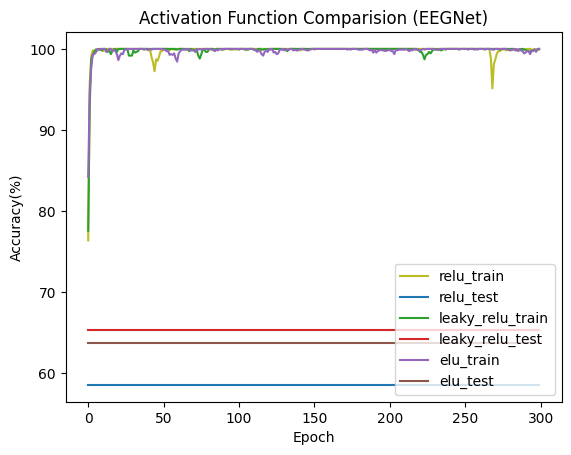

In [72]:
# hyperparameters
batch_size = 64
learning_rate = 1e-2
epochs = 300
activation_funs = ["ReLU", "LeakyReLU", "ELU"]
accs = []
models = []

for i in range(len(activation_funs)):
    models.append(Model(EEGNET(activation_funs[i]), batch_size, learning_rate, epochs))
    accs.append(models[i].Train(td, tl))
    accs.append(models[i].Predict(pd, pl))

PlotAccuracy(epochs, accs)

In [ ]:
a = torch.tensor([[0.7,-0.3],[0.5,-0.6]])
l = torch.tensor([1,0])
# a = torch.tensor([i.sum() for i in a])
# b = ((a>0)==l).sum()
# b.item()
for v in zip(a, l):
    print(v)

In [ ]:
arr = np.arange(10)
b = 4
lack = len(arr) % b
trained, untrained = arr[:-lack-1], arr[-lack-1:-1]
np.random.shuffle(trained)

res = untrained
res = np.append(res, trained[:lack])
res

array([7, 8, 5, 1])

In [ ]:
xs = ["relu_train", "relu_test", "leakyrelu_train", "leakyrelu_test", "elu_train", "elu_test"]
ys = [[1, 2], [3, 7], [5, 2], [3, 4], [7, 4], [1, 5]]
zs = ["tab:olive", "tab:blue", "tab:green", "tab:red", "tab:purple", "tab:brown"]

for i in range(len(xs)):
    plt.plot(np.arange(2), ys[i], color=zs[i], label=xs[i])
plt.legend(loc='lower right')
plt.show()